In [1]:
import os

def build_depth_map(super_path):
    depth_map_path = {}

    # Walk through the directory tree
    for root, _, files in os.walk(super_path):
        for filename in files:
            if filename.endswith('.png'):
                full_path = os.path.join(root, filename)
                # Remove super_path from the full path to get the relative path
                relative_path = os.path.relpath(full_path, super_path)
                # Split the relative path into parts (folders)
                parts = relative_path.split(os.sep)
                parts[-1]=parts[-1][len('result_merged_depth_'):-len('.png')]
                
                # Initialize nested dictionaries as needed
                current_dict = depth_map_path
                for part in parts[:-1]:  # Iterate over all parts except the last one (filename)
                    current_dict = current_dict.setdefault(part, {})
                
                # Assign the full path to the deepest nested dictionary
                current_dict[parts[-1]] = full_path

    return depth_map_path

def build_depth_map_confidence(super_path):
    depth_map_path = {}

    # Walk through the directory tree
    for root, _, files in os.walk(super_path):
        for filename in files:
            if filename.endswith('.exr'):
                full_path = os.path.join(root, filename)
                # Remove super_path from the full path to get the relative path
                relative_path = os.path.relpath(full_path, super_path)
                # Split the relative path into parts (folders)
                parts = relative_path.split(os.sep)
                parts[-1]=parts[-1][len('result_merged_conf_'):-len('.exr')]
                
                # Initialize nested dictionaries as needed
                current_dict = depth_map_path
                for part in parts[:-1]:  # Iterate over all parts except the last one (filename)
                    current_dict = current_dict.setdefault(part, {})
                
                # Assign the full path to the deepest nested dictionary
                current_dict[parts[-1]] = full_path

    return depth_map_path



In [2]:
import os
from tqdm import tqdm

def find_train_folders(directory):
    train_folders = []
    for root, dirs, files in tqdm(os.walk(directory)):
        for dir in dirs:
            if dir.startswith('train'):
                train_folders.append(os.path.join(root, dir))
    return train_folders

train_path=find_train_folders('/mnt/Velocity Vault/Autofocus/Train/')
train_path=train_path[:3]
print("hell")

depth_map_path={}
depth_map_path_temp={}

for path in train_path:
    depth_map_path_temp=build_depth_map(path+"/merged_depth")
    depth_map_path.update(depth_map_path_temp)

depth_map_confidence_path={}
depth_map_confidence_path_temp={}

for path in train_path:
    depth_map_confidence_path_temp=build_depth_map_confidence(path+"/merged_conf")
    depth_map_confidence_path.update(depth_map_confidence_path_temp)




import pprint
pprint.pprint(depth_map_path)
pprint.pprint(depth_map_confidence_path)


71904it [00:04, 16683.59it/s]

hell
{'apt1_0': {'bottom': '/mnt/Velocity '
                      'Vault/Autofocus/Train/train1/merged_depth/apt1_0/result_merged_depth_bottom.png',
            'center': '/mnt/Velocity '
                      'Vault/Autofocus/Train/train1/merged_depth/apt1_0/result_merged_depth_center.png',
            'left': '/mnt/Velocity '
                    'Vault/Autofocus/Train/train1/merged_depth/apt1_0/result_merged_depth_left.png',
            'right': '/mnt/Velocity '
                     'Vault/Autofocus/Train/train1/merged_depth/apt1_0/result_merged_depth_right.png',
            'top': '/mnt/Velocity '
                   'Vault/Autofocus/Train/train1/merged_depth/apt1_0/result_merged_depth_top.png'},
 'apt1_1': {'bottom': '/mnt/Velocity '
                      'Vault/Autofocus/Train/train1/merged_depth/apt1_1/result_merged_depth_bottom.png',
            'center': '/mnt/Velocity '
                      'Vault/Autofocus/Train/train1/merged_depth/apt1_1/result_merged_depth_center.png',
    

In [3]:
import numpy as np
import random


def generate_random_patches(size=(504,378)):
    image=np.zeros(size)
    patches=[]
    for _ in (range(100)):
        x=random.randint(16, 487)
        y=random.randint(16, 361)

        #print(x,y)
        
        breaker=False

        for i in range(x-26,x+26):
            for j in range(y-26,y+26):
                if i<0 or i>503 or j<0 or j>377 :
                    continue
                if image[i][j]==1:
                    breaker=True
                    break
            if breaker:
                break

        if breaker:
            continue
        
        x=x-16
        y=y-16

        for i in range(x,x+33):
            for j in range(y,y+33):
                image[i][j]=1

        patches.append((x,y))


    return patches

In [4]:
import numpy as np
import cv2
import OpenEXR
import Imath


def load_exr(file_path):
    exr_file = OpenEXR.InputFile(file_path)
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    r = np.frombuffer(exr_file.channel('R', pt), dtype=np.float32)
    r.shape = (height, width)
    return r

def predict_patches(depth_confidence_path):

    patch_threshold = 4

    depth_map_confidence = load_exr(depth_confidence_path)

    all_patches=generate_random_patches()

    confidence_patch_blocks=[depth_map_confidence[x:x+32,y:y+32] for (x,y) in all_patches]
    median_confidence_patch_block=[np.median(patch.flatten()) for patch in confidence_patch_blocks]

    patch_indices=[i for i, value in enumerate(median_confidence_patch_block) if value >= 0.98]

    if len(patch_indices)>4:
        patch_indices = sorted(range(len(median_confidence_patch_block)), key=lambda i: median_confidence_patch_block[i], reverse=True)[:patch_threshold]

    patches=[all_patches[patch_index] for patch_index in patch_indices]

    return patches

def predict_focal_length(depth_map_path,patch):
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    depth_values=depth_map[patch[0]:patch[0]+32,patch[1]:patch[1]+32]
    depth_values=depth_values.flatten()

    # Define max and min values
    max_depth = 100.0
    min_depth = 0.2

    depth_map_in_meters = (max_depth * min_depth) / (max_depth - (max_depth - min_depth) * (depth_values / 255.0))

    # Compute the median value in the entire depth map
    median_depth = np.median(depth_map_in_meters)

    final_focus=median_depth*1000

    return final_focus

slice_focal_length=[3910.92,2289.27,1508.71,1185.83,935.91,801.09,700.37,605.39,546.23,486.87,447.99,407.40,379.91,350.41,329.95,307.54,291.72,274.13,261.53,247.35,237.08,225.41,216.88,207.10,198.18,191.60,183.96,178.29,171.69,165.57,160.99,155.61,150.59,146.81,142.35,138.98,134.99,131.23,127.69,124.99,121.77,118.73,116.40,113.63,110.99,108.47,106.54,104.23,102.01]

def find_closest(value, num_list):
    closest_value = min(num_list, key=lambda x: abs(x - value))
    return closest_value

def predict_slice(depth_map_path,depth_confidence_path):
    truth=[]

    patches=predict_patches(depth_confidence_path)
    
    for patch in patches:
        predicted_focus=predict_focal_length(depth_map_path,patch)
        closest_value = find_closest(predicted_focus, slice_focal_length)
        true_slice=slice_focal_length.index(closest_value)
        # manual annotation
        # true_slice=true_slice-1 if true_slice !=0 else true_slice
        truth.append((patch[0],patch[1],true_slice))

    return truth

In [5]:
from tqdm import tqdm
import copy

ground_truth=copy.deepcopy(depth_map_path)

for image_type in tqdm(ground_truth):
    for pos in ground_truth[image_type]:
        ground_truth[image_type][pos]=predict_slice(depth_map_path[image_type][pos],depth_map_confidence_path[image_type][pos])

import pprint
pprint.pprint(ground_truth)

100%|██████████| 151/151 [00:18<00:00,  8.33it/s]


{'apt1_0': {'bottom': [(24, 17, 0), (81, 183, 6), (214, 8, 6), (291, 290, 9)],
            'center': [(14, 198, 0), (370, 100, 6), (31, 265, 4), (28, 101, 0)],
            'left': [(155, 95, 5), (435, 157, 8), (455, 271, 9), (143, 334, 8)],
            'right': [(164, 225, 7),
                      (389, 193, 8),
                      (213, 251, 5),
                      (129, 268, 7)],
            'top': [(142, 218, 6), (207, 77, 4), (306, 308, 6), (288, 25, 5)]},
 'apt1_1': {'bottom': [(26, 240, 0), (166, 214, 2), (299, 76, 4), (38, 105, 0)],
            'center': [(351, 70, 4), (334, 220, 4), (447, 161, 5), (36, 29, 0)],
            'left': [(275, 327, 3), (277, 134, 3), (313, 49, 3), (122, 326, 0)],
            'right': [(55, 140, 0), (395, 135, 5), (39, 334, 0), (73, 22, 0)],
            'top': [(280, 308, 2), (112, 115, 0), (206, 65, 1), (376, 212, 4)]},
 'apt1_2': {'bottom': [(26, 47, 0), (261, 145, 4), (91, 175, 0), (39, 278, 0)],
            'center': [(198, 66, 3), (2, 50, 0)

In [6]:
patch_count=[]

for key1 in ground_truth:
    for key2 in ground_truth[key1]:
        patch_count.append(len(ground_truth[key1][key2]))

print(min(patch_count)," ",np.mean(patch_count)," ",max(patch_count))

0   3.833112582781457   4


In [7]:
import cv2

def resize_image_by_factor(image, factor=4):    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate new dimensions
    new_width = width // factor
    new_height = height // factor

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized_image


In [125]:
super_path='/mnt/Velocity Vault/Autofocus/Train/train3/'
image_type='macrofood1_4/'
pat=2

In [126]:
def mean_local_norm_dist_sq(image, sigma=4):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Blur the image with a Gaussian filter
    blurred = cv2.GaussianBlur(gray, (0, 0), sigma)
    
    # Compute the distortion square
    distortion_sq = (gray - blurred) ** 2
    
    # Calculate the mean of the distortion square
    mlnds_score = np.mean(distortion_sq)
    
    return mlnds_score

def mlnd_image_index(image_list, sigma=4):
    max_focus_score = -np.inf
    most_focused_index = -1

    for idx, image in enumerate(image_list):
        focus_score = mean_local_norm_dist_sq(image, sigma=sigma)
        
        if focus_score > max_focus_score:
            max_focus_score = focus_score
            most_focused_index = idx
    
    return most_focused_index

In [127]:
import cv2
import pywt
import numpy as np

def mean_wavelet_log_ratio(image, level=3):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute wavelet transform
    coeffs = pywt.wavedec2(gray, 'db1', level=level)
    
    # Compute the log ratio
    log_ratios = []
    for i in range(1, len(coeffs)):
        cH, cV, cD = coeffs[i]
        log_ratio = np.log(np.abs(cH) + np.abs(cV) + np.abs(cD) + 1)  # Adding 1 to avoid log(0)
        log_ratios.append(np.mean(log_ratio))
    
    # Return the mean of log ratios
    return np.mean(log_ratios)

def mwlr_image_index(image_list, level=3):
    max_focus_score = -np.inf
    most_focused_index = -1

    for idx, image in enumerate(image_list):
        focus_score = mean_wavelet_log_ratio(image, level=level)
        
        if focus_score > max_focus_score:
            max_focus_score = focus_score
            most_focused_index = idx
    
    return most_focused_index


In [128]:
import cv2
import numpy as np

def most_focused_image_index(images):
    max_variance = -1
    focused_index = -1
    
    for i, img in enumerate(images):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Compute the Laplacian of the image
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        
        # Calculate the variance of the Laplacian
        variance = laplacian.var()
        
        # Update the most focused image index if the current one is more focused
        if variance > max_variance:
            max_variance = variance
            focused_index = i
    
    return focused_index

# Example usage:
# Assuming images is a list of 49 images with each image being a numpy array of size (128, 128, 3)
# focused_image_index = most_focused_image_index(images)


(180, 52)
(504, 378, 3)
Model - Red 6
Contrast - Green 6
MWLR - Blue 20
MLND - Black 5


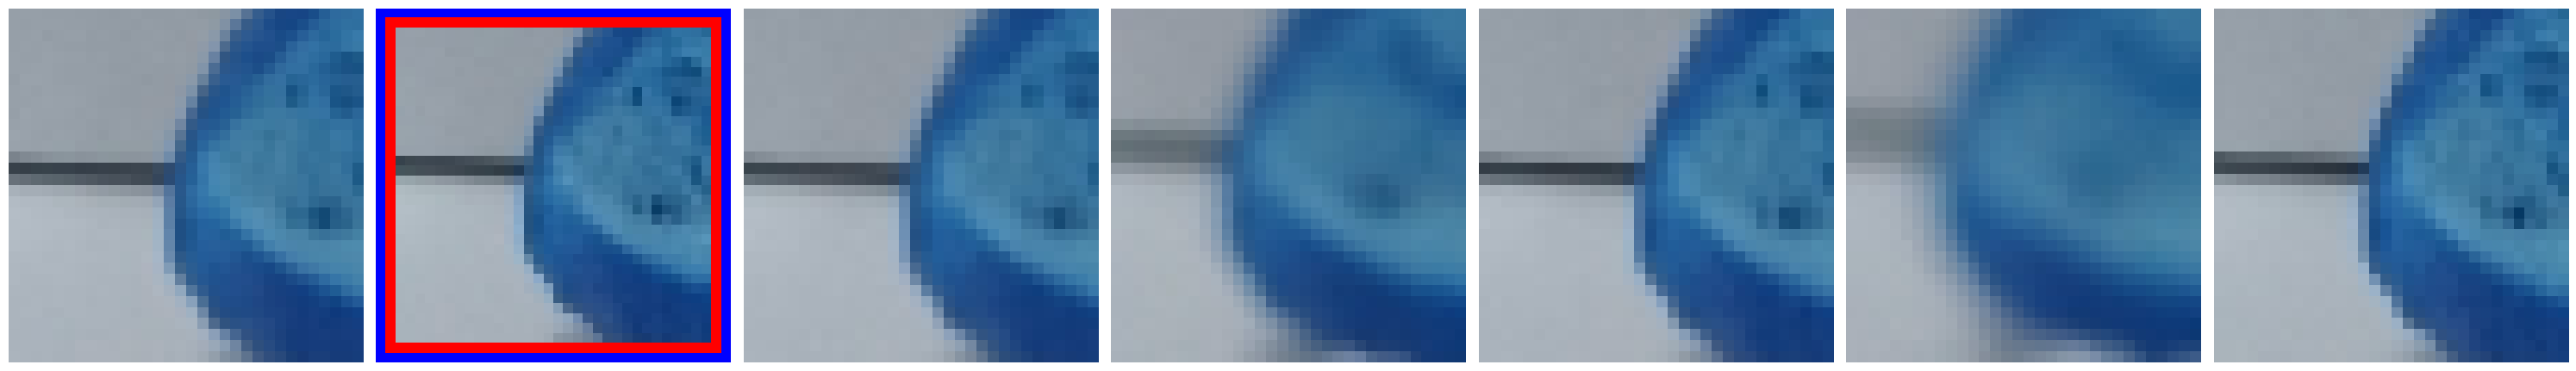

187.0
745.8975634012926


In [129]:


import os
import cv2

# Directory path where images are stored
path=super_path+'scaled_images/'+image_type

# Filename pattern to filter
filename_pattern = 'result_scaled_image_center.jpg'

# Initialize an empty list to store images
images = []

# Recursively traverse the directory tree
for root, _, files in os.walk(path):
    for filename in files:
        if filename == filename_pattern:
            # Construct the full file path
            file_path = os.path.join(root, filename)
            
            # Open the image using PIL (assuming PNG format)
            image = cv2.imread(file_path)
            
            #  the image to the list
            images.append(image)


# Now 'images' contains all images named 'result_up_pd_left_center.png' from the directory and its subfolders
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 49 images stored in a list called images
# Each image in images should be a numpy array or a PIL Image object

# Example list of 49 images (using placeholder numpy arrays)
#images = [np.random.random((100, 100)) for _ in range(49)]

# Determine layout of subplots (7x7 grid for 49 images)
num_images = len(images)
rows = 1
cols = 7

from operator import truth
import numpy as np
import matplotlib.pyplot as plt
import cv2

truth_slice=ground_truth[image_type[:-1]]['center'][pat][2]
patch=(ground_truth[image_type[:-1]]['center'][pat][0],ground_truth[image_type[:-1]]['center'][pat][1])
print(patch)
print(images[0].shape)
images=[im[patch[0]:patch[0]+32,patch[1]:patch[1]+32] for im in images]
foc_slice=most_focused_image_index(images)
mwlr_slice=mwlr_image_index(images)
mlnd_slice=mlnd_image_index(images)
print("Model - Red",truth_slice)
print("Contrast - Green",foc_slice)
print("MWLR - Blue",mwlr_slice)
print("MLND - Black",mlnd_slice)

#images=[cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in images]
# Parameters for border
border_color = [255, 0, 0]  # Red color in RGB
border_size = 1

def add_border(image, border_size, border_color):
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=border_color)

# Adding border to the xth image
images[truth_slice] = add_border(images[truth_slice], border_size, [255, 0, 0])
images[foc_slice] = add_border(images[foc_slice], border_size, [0,0,255])
# images[mwlr_slice] = add_border(images[mwlr_slice], border_size, [0,0,255])
# images[mlnd_slice] = add_border(images[mlnd_slice], border_size, [0,255,0])

bord=[]
bord.append(truth_slice)
bord.append(foc_slice)
# bord.append(mwlr_slice)
# bord.append(mlnd_slice)

specific_indices = [0, 6, 13, 27, 34, 41, 48]+bord
specific_indices=sorted(specific_indices)

def remove_duplicates(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]

specific_indices=remove_duplicates(specific_indices)

im_show = [images[i] for i in specific_indices] + [images[i] for i in bord]

# Create a figure with 7x7 subplots
row_size=len(specific_indices)
fig, axes = plt.subplots(1, row_size, figsize=(30, 30))

# Plot each image
i=0
for ax in (axes.flat):
    ax.imshow(im_show[i])
    ax.axis('off')  # Hide the axes
    i+=1

# Display the grid
plt.tight_layout()
plt.show()

depth=cv2.imread(super_path+'merged_depth/'+image_type+'result_merged_depth_center.png')
depth=depth[patch[0]:patch[0]+32,patch[1]:patch[1]+32]
med=np.median(depth)
print(med)

max_depth = 100.0
min_depth = 0.2

med = (max_depth * min_depth) / (max_depth - (max_depth - min_depth) * (med / 255.0))

print(med*1000)





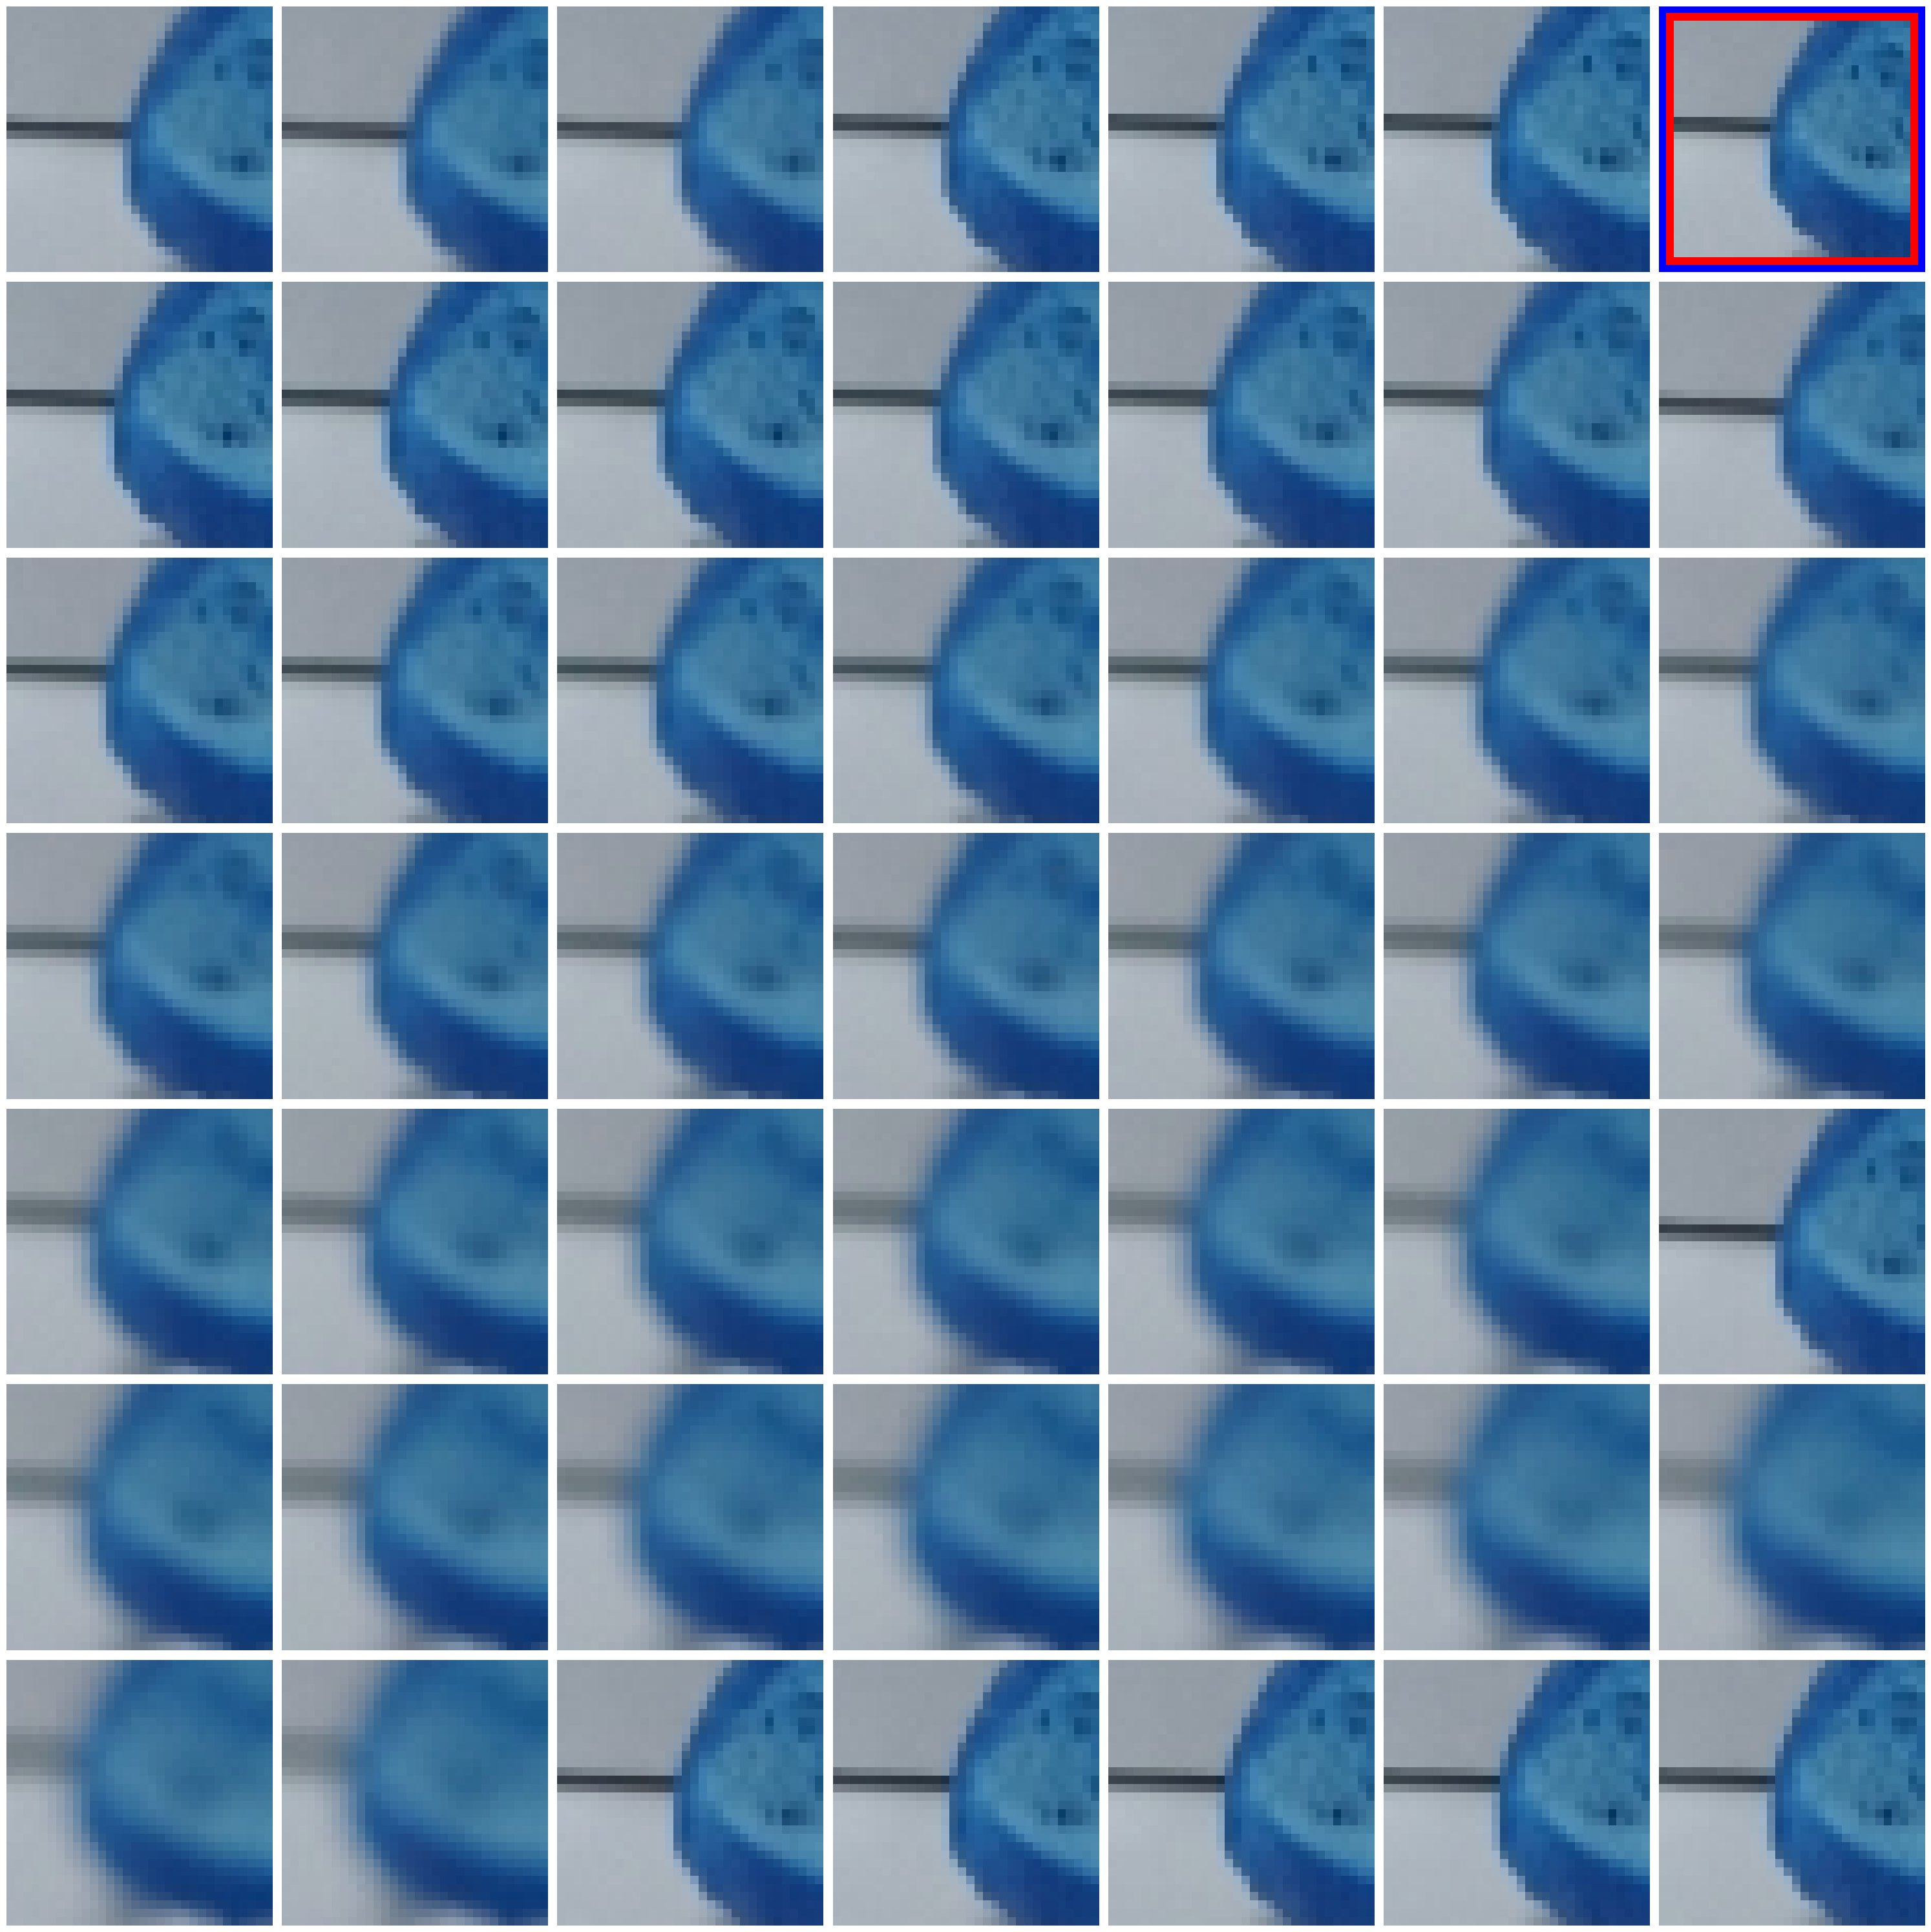

In [130]:


fig, axes = plt.subplots(7, 7, figsize=(30, 30))

i=0
for ax in (axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide the axes
    i+=1

# Display the grid
plt.tight_layout()
plt.show()



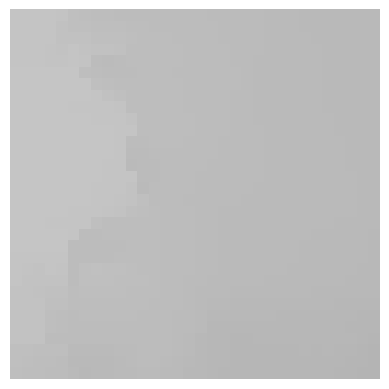

In [131]:


import os
import cv2

# Directory path where images are stored
path=super_path+'merged_depth/'+image_type

# Filename pattern to filter
filename_pattern = 'result_merged_depth_center.png'

image=cv2.imread(path+filename_pattern)
patch=(ground_truth[image_type[:-1]]['center'][pat][0],ground_truth[image_type[:-1]]['center'][pat][1])
image=image[patch[0]:patch[0]+32,patch[1]:patch[1]+32]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()
